# 1 Data Prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_fdp = pd.read_csv("/content/drive/MyDrive/P15/Section-1/AWL Simulation/zone.xls")

In [4]:
df_fdp.head()

,Zone No.,Municipality,Population Density,Area_SqKM,Main Road
0,1,Doha,352.946120,0.373995,0
1,2,Doha,57.318806,0.383818,0
2,3,Doha,446.728705,0.371590,0
3,4,Doha,10090.918970,0.326333,0
4,5,Doha,16489.430780,0.219777,0


Remove the zone 99: three small islands, total area is 2.7km2, 0 population, do not be included in any municipality

In [5]:
df_fdp = df_fdp[df_fdp['Municipality'] != 'zone99']

## deal with special area

- 0 - population density <10 & >10,000 have a large-size nature protected area in the zone;
-
1 - have a medium-size nature protected area in the zone


- 2 - have a small-size nature protected area in the zone
- 3 - normal area

In [6]:
# set coloumn "Special Area"
conditions = [
    # population density < 10
    (df_fdp['Population Density'] < 10),
    # population density > 10,000
    (df_fdp['Population Density'] > 10000),
    # have large nature protected area
    (df_fdp['Zone No.'].isin([78, 76, 73, 94, 98])),
    # have medium nature protected area
    (df_fdp['Zone No.'].isin([72, 95, 97])),
    # have small nature protected area
    (df_fdp['Zone No.'].isin([75, 74]))
]

# set coloumn value of conditions
choices = [0, 0, 0, 1, 2]

# normal area -- 3
df_fdp['Special Area'] = np.select(conditions, choices, default=3)

df_fdp.head()

,Zone No.,Municipality,Population Density,Area_SqKM,Main Road,Special Area
0,1,Doha,352.946120,0.373995,0,3
1,2,Doha,57.318806,0.383818,0,3
2,3,Doha,446.728705,0.371590,0,3
3,4,Doha,10090.918970,0.326333,0,0
4,5,Doha,16489.430780,0.219777,0,0


In [7]:
from IPython.display import Image
Image(filename="D:\\Semester 2\\Applying data science\\FDP\\special area.jpg", width=400, height=300)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Semester 2\\Applying data science\\FDP\\special area.jpg'

## calculate population density score

Population density score is only used to calculate the industry score. We still use the population density (MinMaxScaling) to cluster.

In [8]:
# Calculate quantiles
quantiles = df_fdp['Population Density'].quantile([0.25, 0.50, 0.75])
quantiles

0.25      72.915508
0.50    1552.232971
0.75    7358.967309
Name: Population Density, dtype: float64

0: >Q3 or <Q1 (>7359 or <73)

1: 5000 ~ 7359

2: 2000 ~ 5000


3: 1000 ~ 2000


4: 73 ~ 1000

In [9]:
quantiles = df_fdp['Population Density'].quantile([0.25, 0.50, 0.75])

# design the population density score
def score_population_density(density, quantiles):
    if density < quantiles[0.25] or density > quantiles[0.75]:
        return 0
    elif density > 5000:
        return 1
    elif density > 2000:
        return 2
    elif density > 1000:
        return 3
    else:
        return 4

df_fdp['Population Density Score'] = df_fdp['Population Density'].apply(score_population_density, quantiles=quantiles)

## calculate industry score

- industry score: main road * 40% +population density score * 30% + special area * 30%
- All three aspects are important, but transportation convenience is given a weight of 40%, 30% and 30% respectively due to its direct impact on logistics and cost control.

*Note: If the population density score is 0 or special area score is 0, we set industry score 0.

In [10]:
# calculate the industry score
df_fdp['Industry Score'] = 0

mask = (df_fdp['Special Area'] != 0) & (df_fdp['Population Density Score'] != 0)
df_fdp.loc[mask, 'Industry Score'] = df_fdp['Main Road'] * 0.4 + df_fdp['Special Area'] * 0.3 + df_fdp['Population Density Score'] * 0.3

df_fdp

,Zone No.,Municipality,Population Density,Area_SqKM,Main Road,Special Area,Population Density Score,Industry Score
0,1,Doha,352.946120,0.373995,0,3,4,2.1
1,2,Doha,57.318806,0.383818,0,3,0,0.0
2,3,Doha,446.728705,0.371590,0,3,4,2.1
3,4,Doha,10090.918970,0.326333,0,0,0,0.0
4,5,Doha,16489.430780,0.219777,0,0,0,0.0
...,...,...,...,...,...,...,...,...
86,95,Al Wakra,7.155703,903.055979,0,0,0,0.0
87,96,Al Rayyan,3.437531,948.355088,1,0,0,0.0
88,97,Al Rayyan,0.560834,420.802085,0,0,0,0.0
89,98,Al Wakra,0.005678,704.443625,0,0,0,0.0


# 2 Visualisation

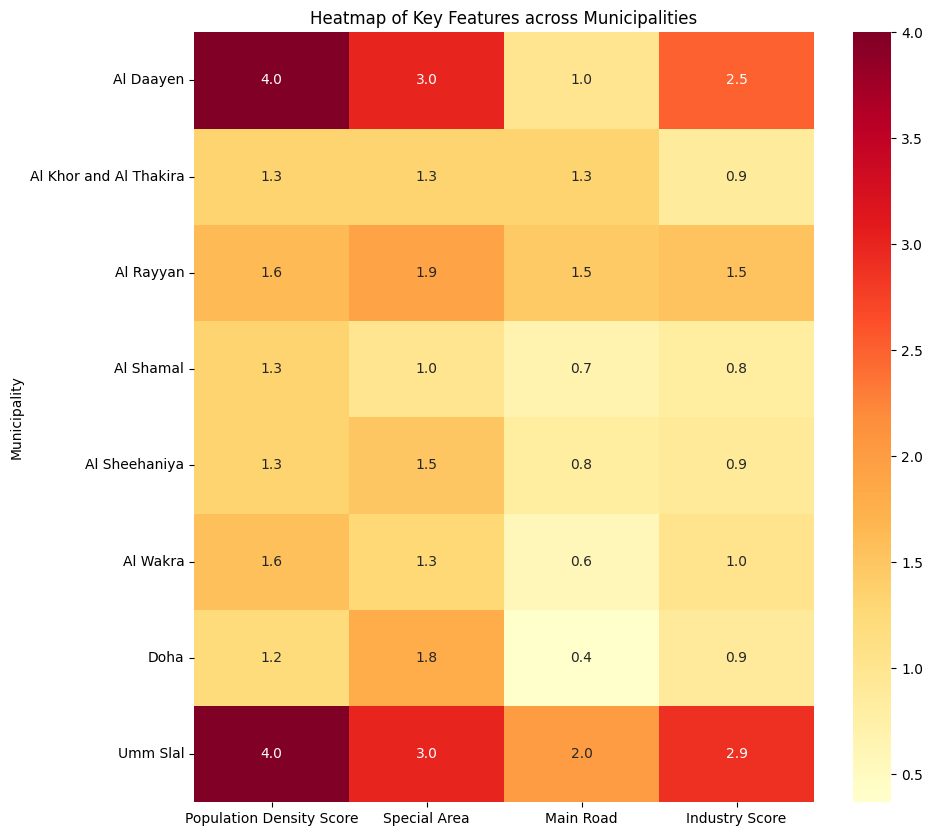

In [11]:
# create the heatmap group by municipalities
selected_columns = ['Population Density Score', 'Special Area', 'Main Road', 'Industry Score']
heatmap_data = df_fdp.groupby('Municipality')[selected_columns].mean()

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title('Heatmap of Key Features across Municipalities')
plt.show()

As the heatmap shows, areas with small populations and no special areas tend to have better transportation and higher industrial scores.

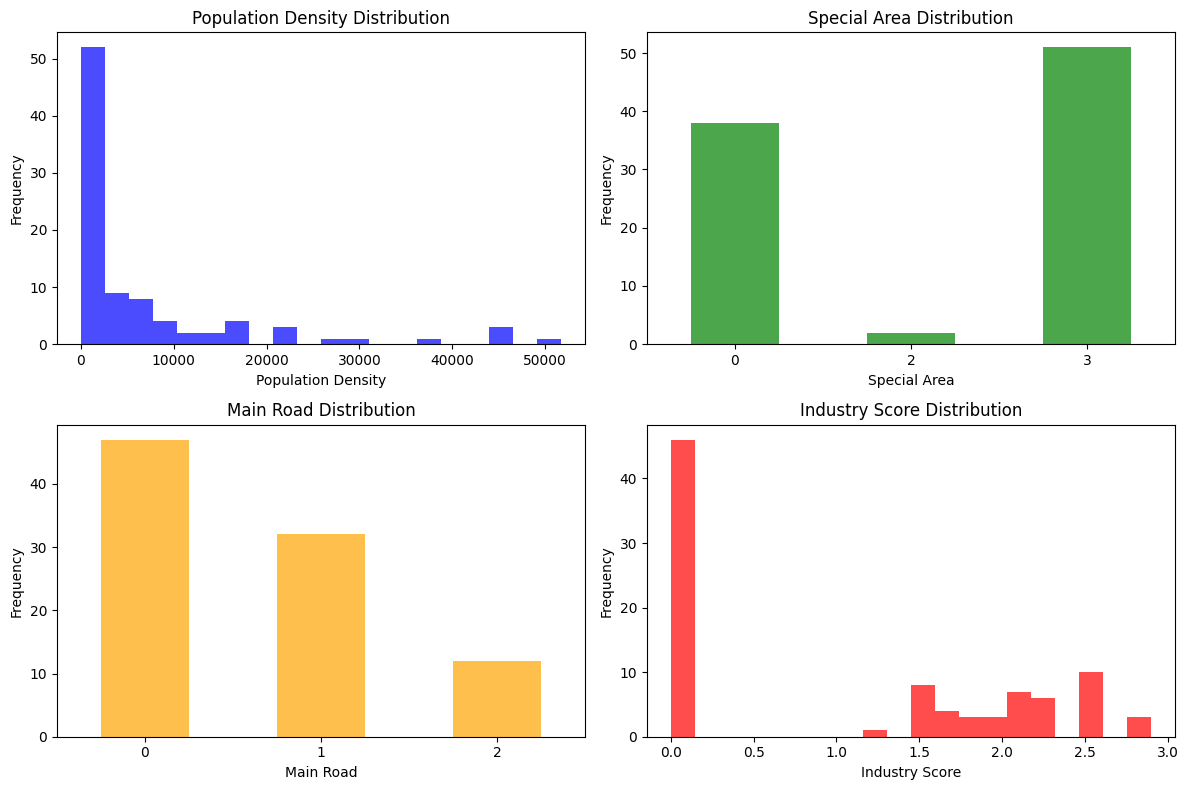

In [12]:
plt.figure(figsize=(12, 8))

# plot the distribution of Population Density
plt.subplot(2, 2, 1)
plt.hist(df_fdp['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# plot the distribution of Special Area
plt.subplot(2, 2, 2)
df_fdp['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution')
plt.xlabel('Special Area')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# plot the distribution of Main Road
plt.subplot(2, 2, 3)
df_fdp['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution')
plt.xlabel('Main Road')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# plot the distribution of Industry Score
plt.subplot(2, 2, 4)
plt.hist(df_fdp['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

Population density score is only used to calculate the industrial score, and using population density modelling can better capture clustering relationships. However, the population density shows an extremely skewed distribution, and most zones have extremely low population density. In order to preserve the original distribution of the data without affecting the subsequent unsupervised classification, we use the MinMaxScaler for population density.

There are 45 zones that result in an industrial score of 0 due to either too high/low population density or large areas of nature reserves within the zone. We can remove zones with an industry score of 0 before cluster analysis (not suitable for awl)

In [13]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
population_density = df_fdp[['Population Density']]
population_density_scaled = scaler.fit_transform(population_density)
df_fdp['Scaled Population Density'] = population_density_scaled

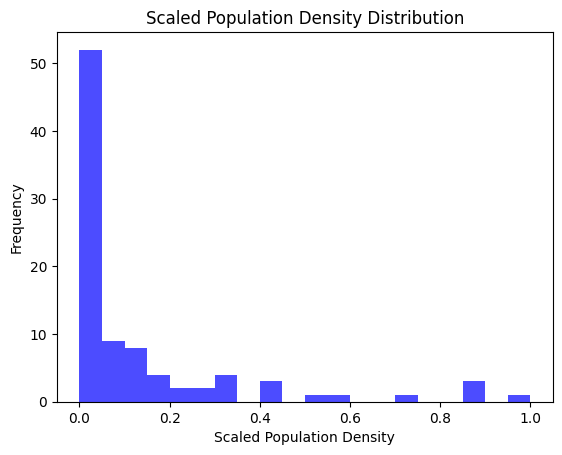

In [14]:
# plot the new distribution
plt.hist(df_fdp['Scaled Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Scaled Population Density Distribution')
plt.xlabel('Scaled Population Density')
plt.ylabel('Frequency')
plt.show()

In [15]:
df_remove_0industry = df_fdp[df_fdp['Industry Score'] != 0].copy()

The code above remove the 0 industry score zones which are not suitable for building a awl.

# 3 Clustering Analyses

## 3.1 First Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

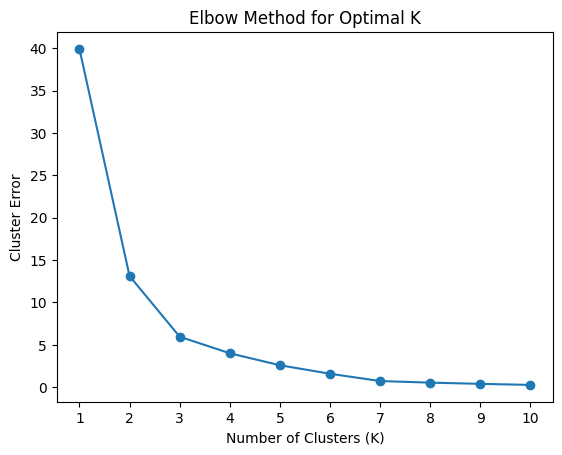

In [16]:
from sklearn.cluster import KMeans

# select features used in clustering modelling
selected_features = ['Scaled Population Density', 'Special Area', 'Main Road', 'Industry Score']

X = df_remove_0industry[selected_features]

# select the range of k
k_range = range(1, 11)
cluster_errors = []

# calculate clustering errors under different K values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_errors.append(kmeans.inertia_)

# create the elbow plot to choose the k value
plt.plot(k_range, cluster_errors, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cluster Error')
plt.xticks(k_range)
plt.show()

The figure shows that the decline trend slows down significantly after k=3. Therefore, k=3 is chosen as the number of clusters.

In [17]:
from sklearn.cluster import KMeans

selected_features = ['Scaled Population Density', 'Special Area', 'Main Road', 'Industry Score']

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_remove_0industry[selected_features])

df_remove_0industry['Cluster'] = kmeans.labels_

for cluster_label in range(3):
    cluster_data = df_remove_0industry[df_remove_0industry['Cluster'] == cluster_label]['Zone No.']
    print(f"Cluster {cluster_label} contains the following Zone Nos.:")
    print(cluster_data.to_list())
    print()

Cluster 0 contains the following Zone Nos.:
[29, 36, 41, 44, 46, 47, 69, 70, 79, 80, 81, 90, 91, 92]

Cluster 1 contains the following Zone Nos.:
[1, 3, 7, 18, 20, 21, 28, 30, 31, 33, 48, 58, 61, 63, 64, 65, 66, 67, 68]

Cluster 2 contains the following Zone Nos.:
[40, 43, 50, 51, 52, 53, 54, 55, 56, 71, 74, 82]



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## cluster 0

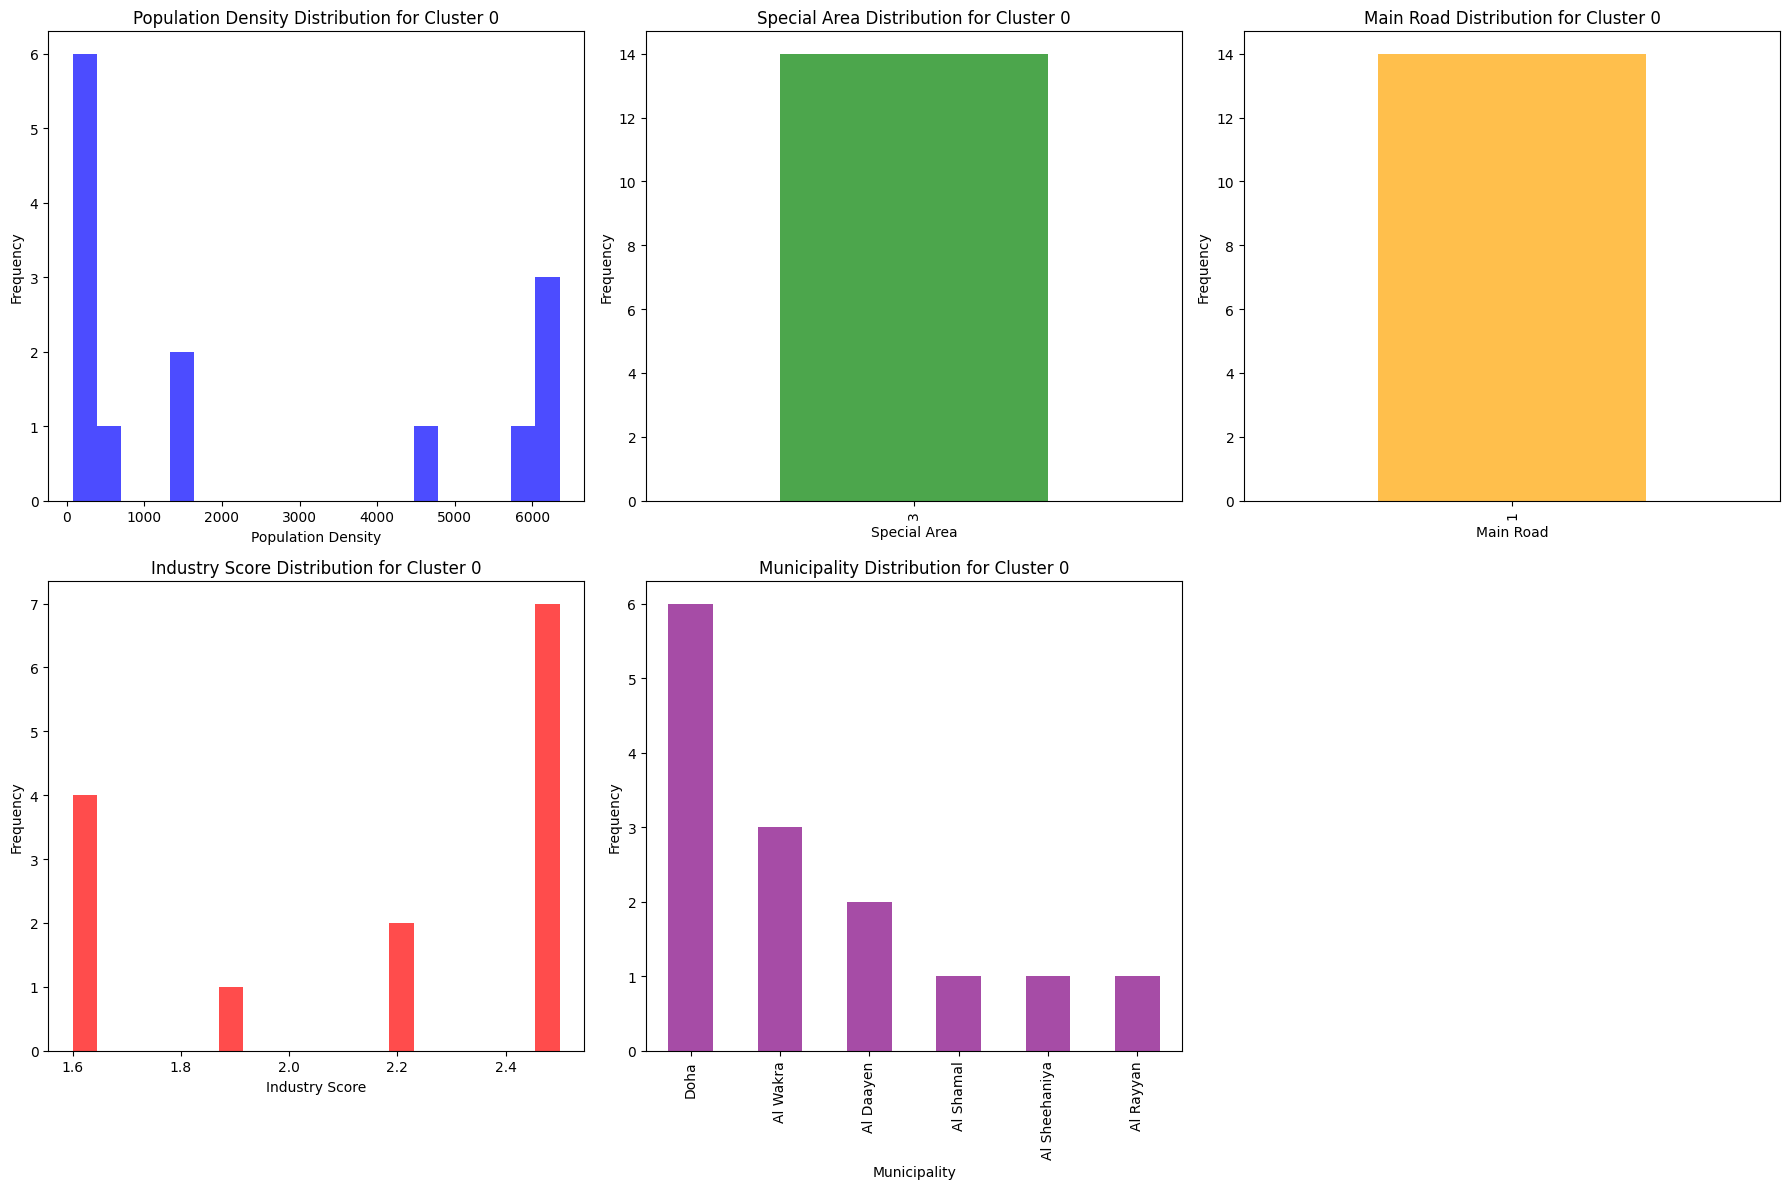

In [18]:
plt.figure(figsize=(18, 12))

# plot the distribution of Population Density for Cluster 0
plt.subplot(2, 3, 1)
plt.hist(df_remove_0industry[df_remove_0industry['Cluster'] == 0]['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution for Cluster 0')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# plot the distribution of Special Area for Cluster 0
plt.subplot(2, 3, 2)
df_remove_0industry[df_remove_0industry['Cluster'] == 0]['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution for Cluster 0')
plt.xlabel('Special Area')
plt.ylabel('Frequency')

# plot the distribution of Main Road for Cluster 0
plt.subplot(2, 3, 3)
df_remove_0industry[df_remove_0industry['Cluster'] == 0]['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution for Cluster 0')
plt.xlabel('Main Road')
plt.ylabel('Frequency')

# plot the distribution of Industry Score for Cluster 0
plt.subplot(2, 3, 4)
plt.hist(df_remove_0industry[df_remove_0industry['Cluster'] == 0]['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution for Cluster 0')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

# plot the distribution of Municipality for Cluster 0
plt.subplot(2, 3, 5)
df_remove_0industry[df_remove_0industry['Cluster'] == 0]['Municipality'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Municipality Distribution for Cluster 0')
plt.xlabel('Municipality')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

## cluster 1

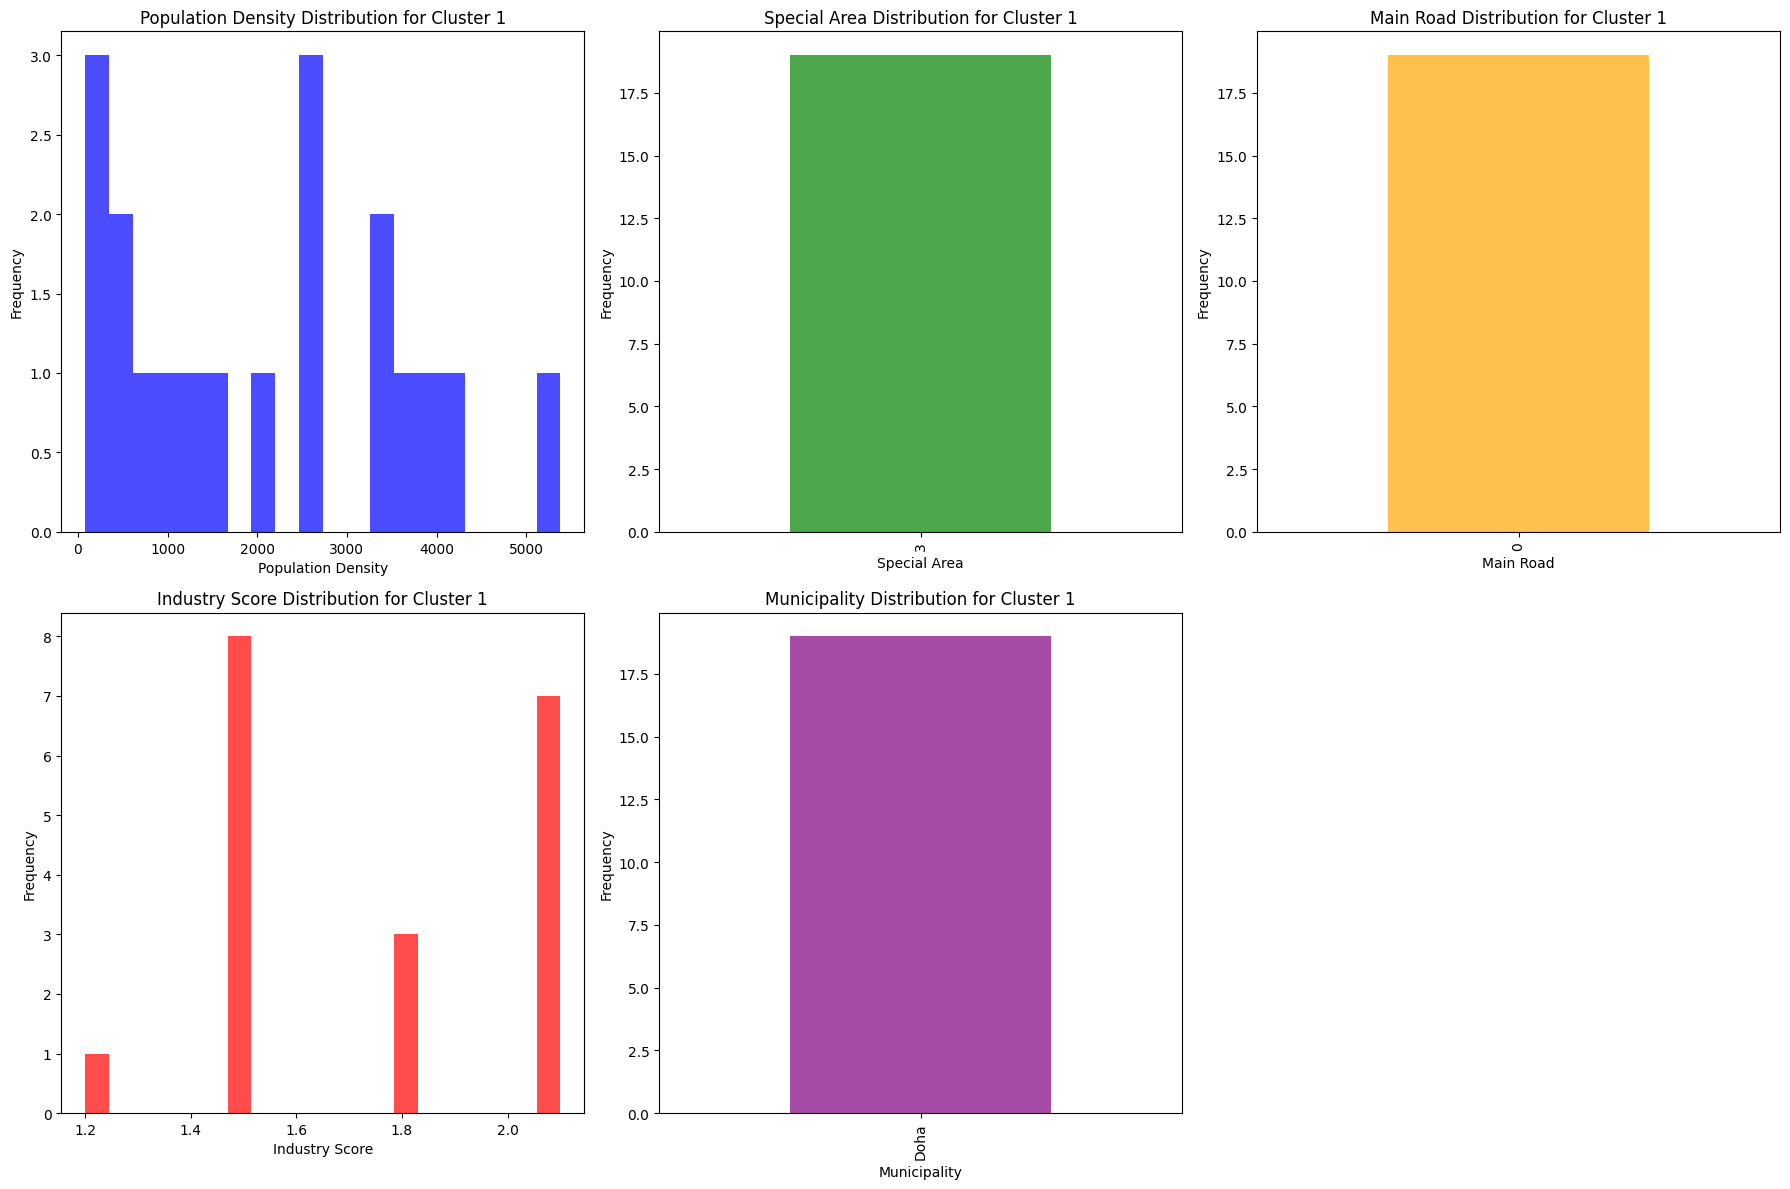

In [19]:
plt.figure(figsize=(18, 12))

# plot the distribution of Population Density for Cluster 1
plt.subplot(2, 3, 1)
plt.hist(df_remove_0industry[df_remove_0industry['Cluster'] == 1]['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution for Cluster 1')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# plot the distribution of Special Area for Cluster 1
plt.subplot(2, 3, 2)
df_remove_0industry[df_remove_0industry['Cluster'] == 1]['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution for Cluster 1')
plt.xlabel('Special Area')
plt.ylabel('Frequency')

# plot the distribution of Main Road for Cluster 1
plt.subplot(2, 3, 3)
df_remove_0industry[df_remove_0industry['Cluster'] == 1]['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution for Cluster 1')
plt.xlabel('Main Road')
plt.ylabel('Frequency')

# plot the distribution of Industry Score for Cluster 1
plt.subplot(2, 3, 4)
plt.hist(df_remove_0industry[df_remove_0industry['Cluster'] == 1]['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution for Cluster 1')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

# plot the distribution of Municipality for Cluster 1
plt.subplot(2, 3, 5)
df_remove_0industry[df_remove_0industry['Cluster'] == 1]['Municipality'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Municipality Distribution for Cluster 1')
plt.xlabel('Municipality')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

## cluster 2

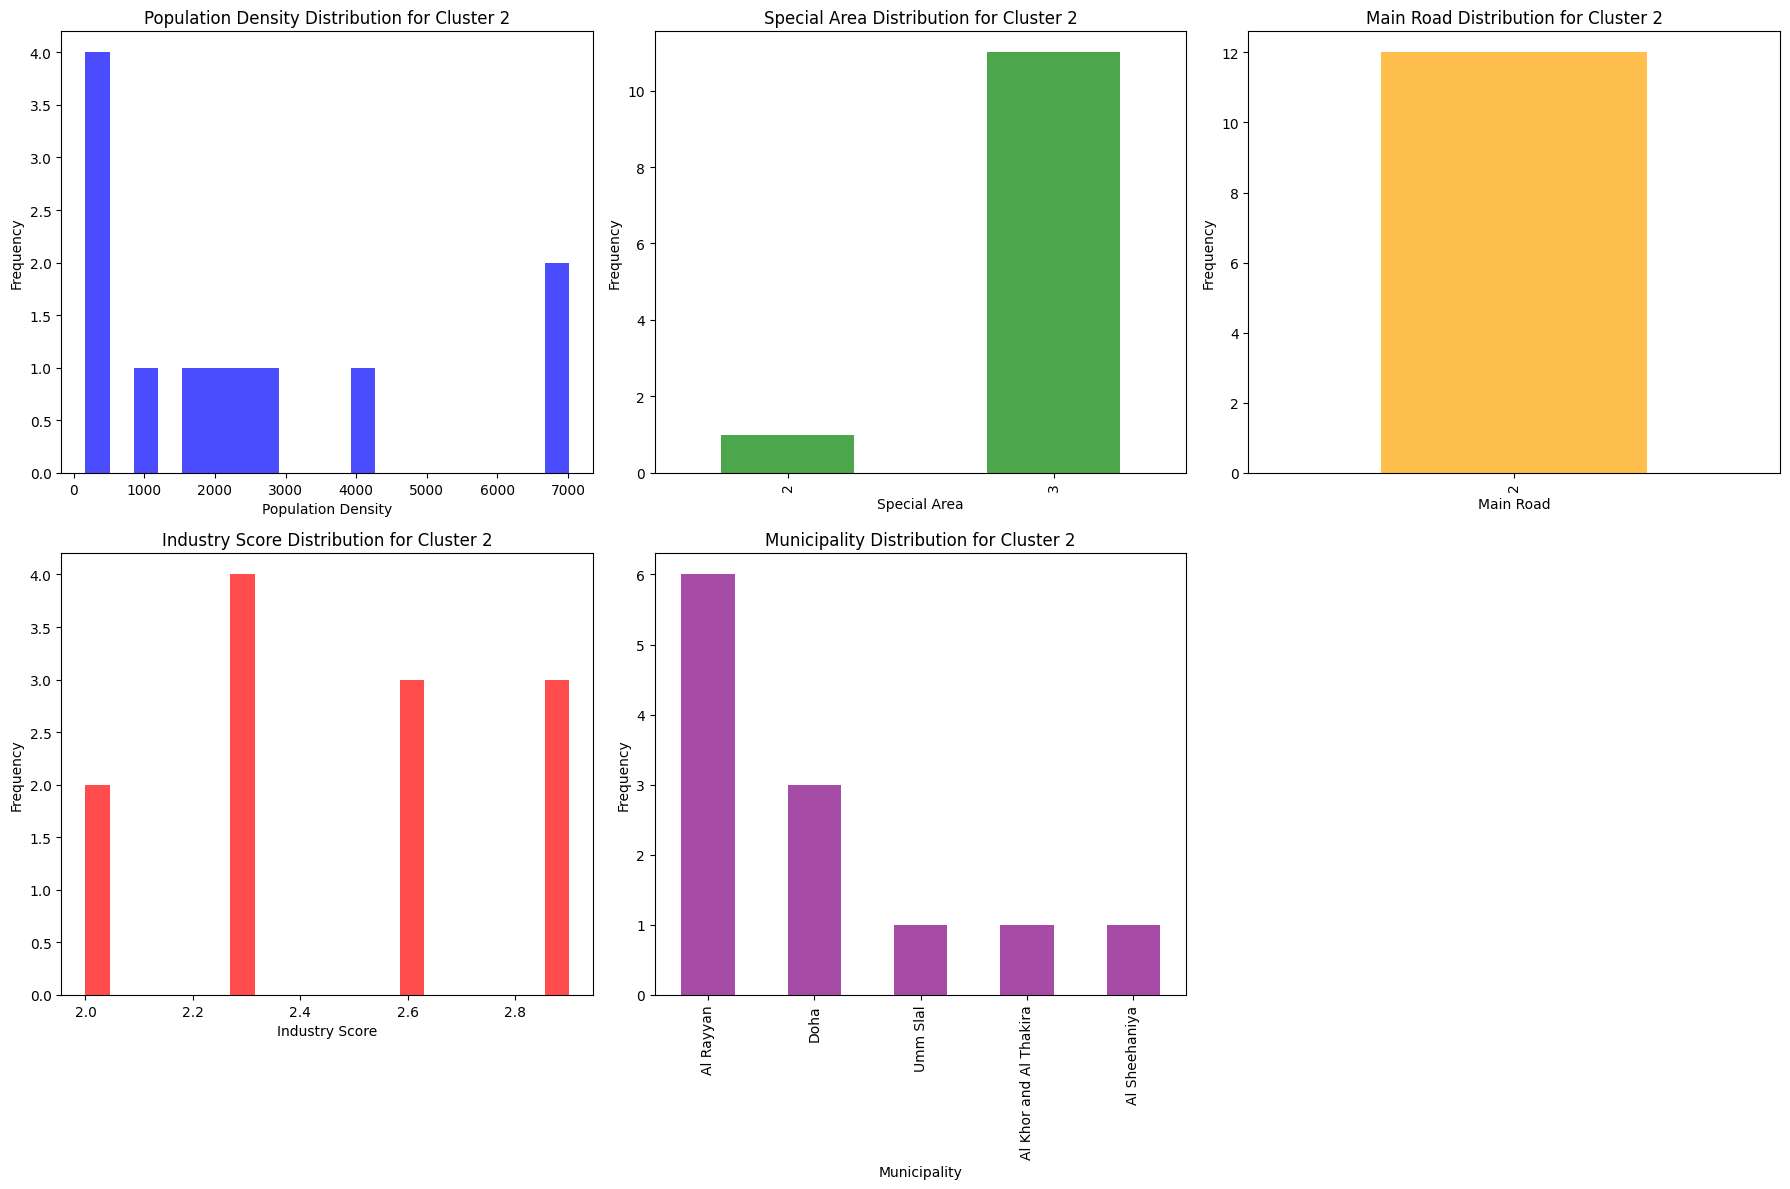

In [20]:
plt.figure(figsize=(18, 12))

# plot the distribution of Population Density for Cluster 2
plt.subplot(2, 3, 1)
plt.hist(df_remove_0industry[df_remove_0industry['Cluster'] == 2]['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution for Cluster 2')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# plot the distribution of Special Area for Cluster 2
plt.subplot(2, 3, 2)
df_remove_0industry[df_remove_0industry['Cluster'] == 2]['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution for Cluster 2')
plt.xlabel('Special Area')
plt.ylabel('Frequency')

# plot the distribution of Main Road for Cluster 2
plt.subplot(2, 3, 3)
df_remove_0industry[df_remove_0industry['Cluster'] == 2]['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution for Cluster 2')
plt.xlabel('Main Road')
plt.ylabel('Frequency')

# plot the distribution of Industry Score for Cluster 2
plt.subplot(2, 3, 4)
plt.hist(df_remove_0industry[df_remove_0industry['Cluster'] == 2]['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution for Cluster 2')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

# plot the distribution of Municipality for Cluster 2
plt.subplot(2, 3, 5)
df_remove_0industry[df_remove_0industry['Cluster'] == 2]['Municipality'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Municipality Distribution for Cluster 2')
plt.xlabel('Municipality')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

After checking (creating plots of each cluster and checking on the Qatar map), we found cluster 2 is very close to the extremely high population density area(in Doha); and has a very small area, which is not suitable for building AWLs.


However, both cluster 0 and cluster 1 have a high industry score, suitable population density and convenient transportation.

Therefore, we merge cluster 0 and cluster 1 to cluster again.

## 3.2 Second Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

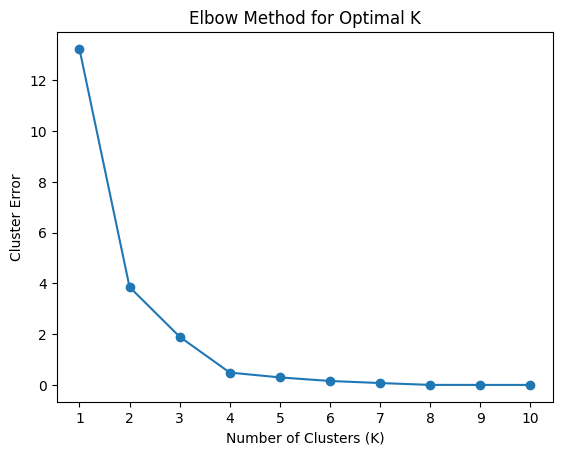

In [21]:
# filter DataFrame to include only data points in Cluster 0 and Cluster 1
df_sub = df_remove_0industry[(df_remove_0industry['Cluster'] == 0) | (df_remove_0industry['Cluster'] == 1)]

# prepare features matrix X
X = df_sub[selected_features]

# select the range of k
k_range = range(1, 11)
cluster_errors = []

# calculate clustering errors under different K values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_errors.append(kmeans.inertia_)

# create the elbow plot to choose the k value
plt.plot(k_range, cluster_errors, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cluster Error')
plt.xticks(k_range)
plt.show()

We will set k = 3 to cluster.

In [22]:
selected_features = ['Scaled Population Density', 'Special Area', 'Main Road', 'Industry Score']

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_sub[selected_features])

df_sub['Cluster'] = kmeans.labels_

for cluster_label in range(3):
    cluster_data = df_sub[df_sub['Cluster'] == cluster_label]['Zone No.']
    print(f"Cluster {cluster_label} contains the following Zone Nos.:")
    print(cluster_data.to_list())
    print()

Cluster 0 contains the following Zone Nos.:
[29, 69, 70, 79, 80, 81, 90, 91, 92]

Cluster 1 contains the following Zone Nos.:
[18, 21, 28, 31, 33, 63, 64, 65, 67]

Cluster 2 contains the following Zone Nos.:
[36, 41, 44, 46, 47]



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-22-8b9be386c5ce>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['Cluster'] = kmeans.labels_


## cluster 0

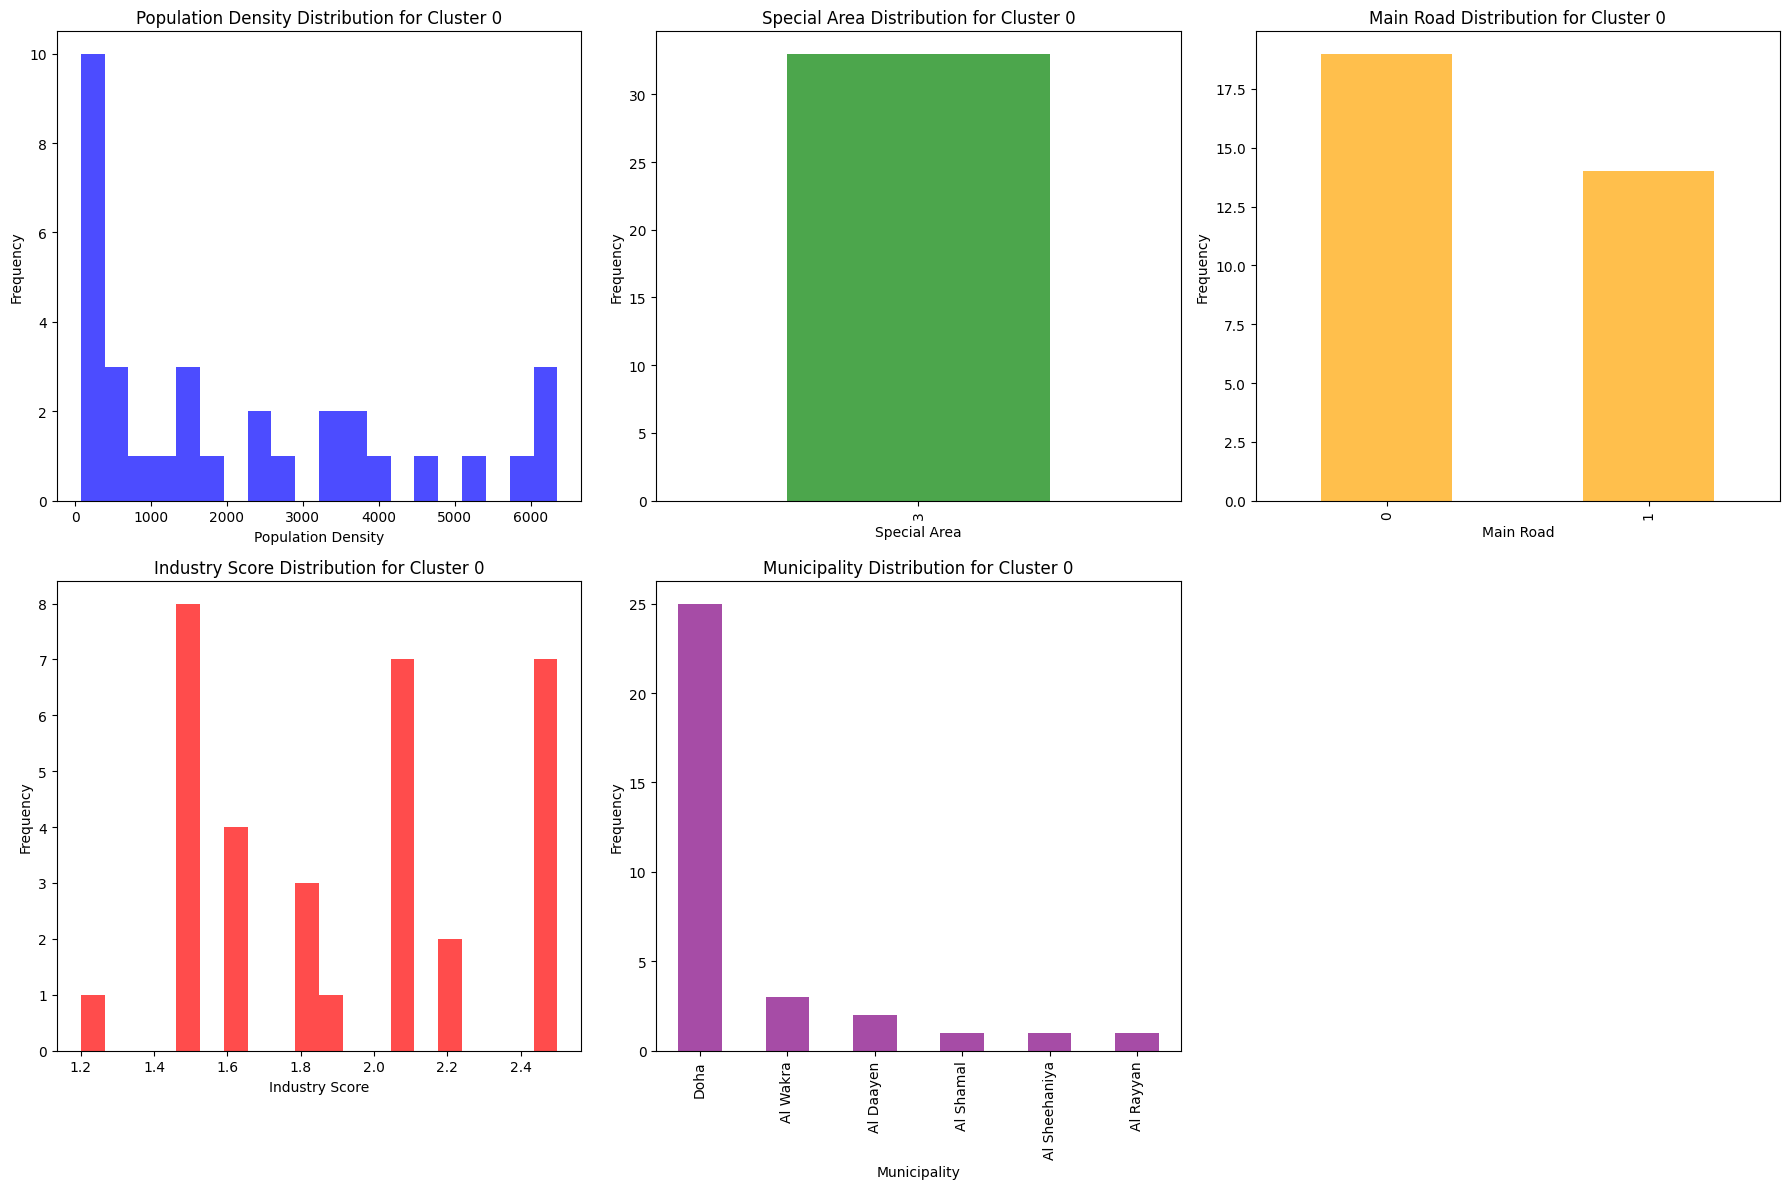

In [23]:
plt.figure(figsize=(18, 12))

# Plot the distribution of Population Density for Cluster 0
plt.subplot(2, 3, 1)
plt.hist(df_sub['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution for Cluster 0')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# Plot the distribution of Special Area for Cluster 0
plt.subplot(2, 3, 2)
df_sub['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution for Cluster 0')
plt.xlabel('Special Area')
plt.ylabel('Frequency')

# Plot the distribution of Main Road for Cluster 0
plt.subplot(2, 3, 3)
df_sub['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution for Cluster 0')
plt.xlabel('Main Road')
plt.ylabel('Frequency')

# Plot the distribution of Industry Score for Cluster 0
plt.subplot(2, 3, 4)
plt.hist(df_sub['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution for Cluster 0')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

# Plot the distribution of Municipality for Cluster 0
plt.subplot(2, 3, 5)
df_sub['Municipality'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Municipality Distribution for Cluster 0')
plt.xlabel('Municipality')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

## cluster 1

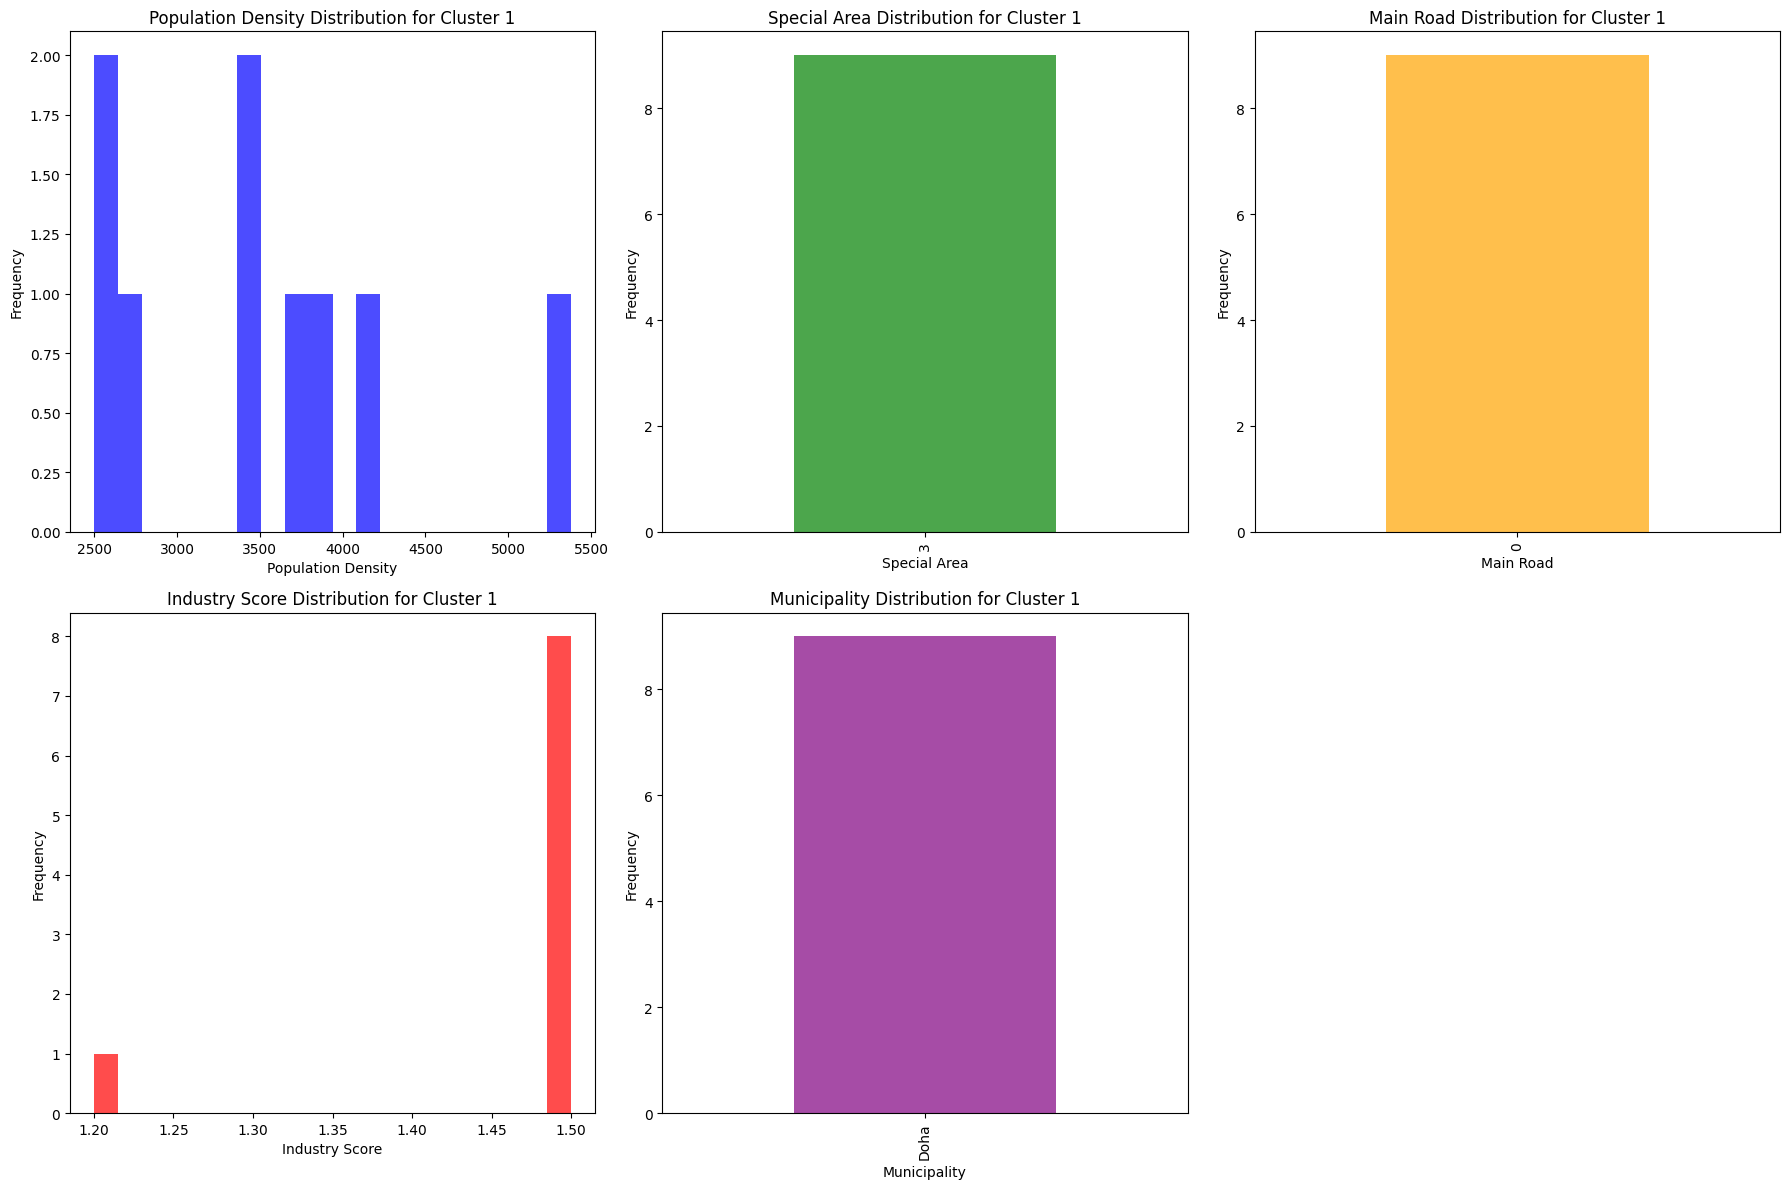

In [24]:
plt.figure(figsize=(18, 12))

# Plot the distribution of Population Density for Cluster 1
plt.subplot(2, 3, 1)
plt.hist(df_sub[df_sub['Cluster'] == 1]['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution for Cluster 1')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# Plot the distribution of Special Area for Cluster 1
plt.subplot(2, 3, 2)
df_sub[df_sub['Cluster'] == 1]['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution for Cluster 1')
plt.xlabel('Special Area')
plt.ylabel('Frequency')

# Plot the distribution of Main Road for Cluster 1
plt.subplot(2, 3, 3)
df_sub[df_sub['Cluster'] == 1]['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution for Cluster 1')
plt.xlabel('Main Road')
plt.ylabel('Frequency')

# Plot the distribution of Industry Score for Cluster 1
plt.subplot(2, 3, 4)
plt.hist(df_sub[df_sub['Cluster'] == 1]['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution for Cluster 1')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

# Plot the distribution of Municipality for Cluster 1
plt.subplot(2, 3, 5)
df_sub[df_sub['Cluster'] == 1]['Municipality'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Municipality Distribution for Cluster 1')
plt.xlabel('Municipality')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

## cluster 2

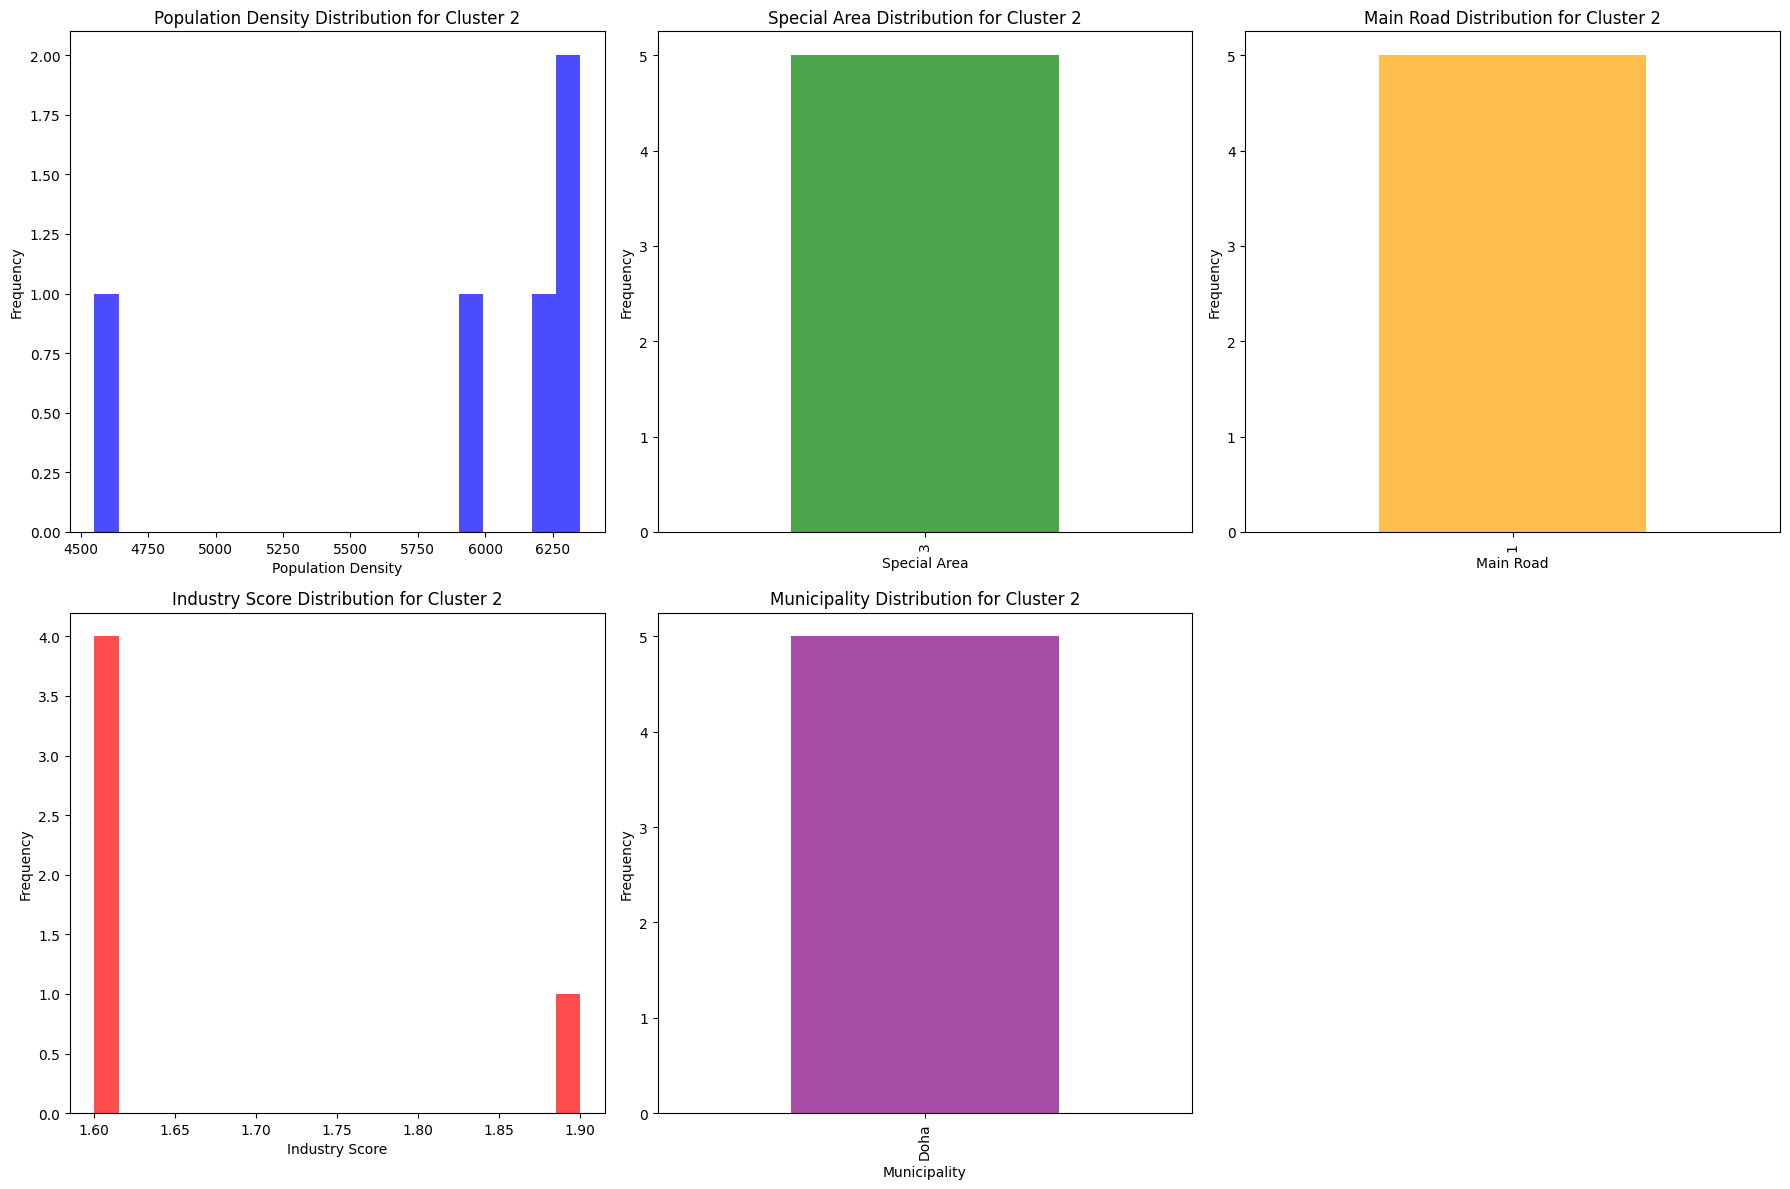

In [25]:
plt.figure(figsize=(18, 12))

# Plot the distribution of Population Density for Cluster 2
plt.subplot(2, 3, 1)
plt.hist(df_sub[df_sub['Cluster'] == 2]['Population Density'], bins=20, color='blue', alpha=0.7)
plt.title('Population Density Distribution for Cluster 2')
plt.xlabel('Population Density')
plt.ylabel('Frequency')

# Plot the distribution of Special Area for Cluster 2
plt.subplot(2, 3, 2)
df_sub[df_sub['Cluster'] == 2]['Special Area'].value_counts().sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Special Area Distribution for Cluster 2')
plt.xlabel('Special Area')
plt.ylabel('Frequency')

# Plot the distribution of Main Road for Cluster 2
plt.subplot(2, 3, 3)
df_sub[df_sub['Cluster'] == 2]['Main Road'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
plt.title('Main Road Distribution for Cluster 2')
plt.xlabel('Main Road')
plt.ylabel('Frequency')

# Plot the distribution of Industry Score for Cluster 2
plt.subplot(2, 3, 4)
plt.hist(df_sub[df_sub['Cluster'] == 2]['Industry Score'], bins=20, color='red', alpha=0.7)
plt.title('Industry Score Distribution for Cluster 2')
plt.xlabel('Industry Score')
plt.ylabel('Frequency')

# Plot the distribution of Municipality for Cluster 2
plt.subplot(2, 3, 5)
df_sub[df_sub['Cluster'] == 2]['Municipality'].value_counts().plot(kind='bar', color='purple', alpha=0.7)
plt.title('Municipality Distribution for Cluster 2')
plt.xlabel('Municipality')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

Both cluster 0 and cluster 1 contain zones suitable for building AWL (suitable population density, high factory score, convenient transportation). In addition, the population density of other zones in cluster 2 except zone 36 is too high, and the industrial score is the lowest compared with the other two clusters. Zone 36, with an area of only 2km2 and a population density of 4550, is also not suitable for building AWL.

Therefore, we removed cluster 2 and combined cluster 0 and cluster 1 for further filtering.

## 3.3 Third Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

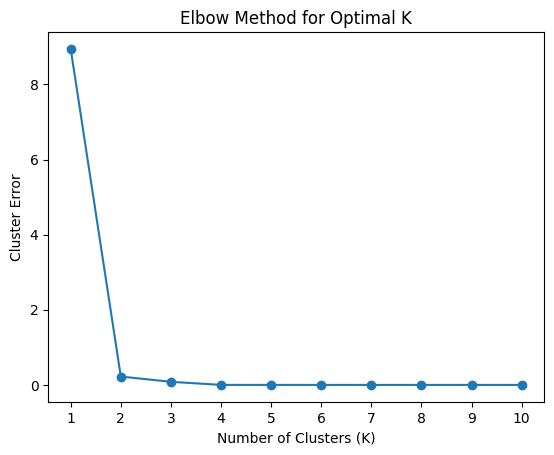

In [26]:
# merge cluster 0 and cluster 1
df_sub2 = pd.concat([df_sub[df_sub['Cluster'] == 0], df_sub[df_sub['Cluster'] == 1]])

# select features used in clustering modeling
selected_features = ['Scaled Population Density', 'Special Area', 'Main Road', 'Industry Score']

# prepare features matrix X
X = df_sub2[selected_features]

# select the range of k
k_range = range(1, 11)
cluster_errors = []

# calculate clustering errors under different K values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_errors.append(kmeans.inertia_)

# create the elbow plot to choose the k value for Cluster 0
plt.plot(k_range, cluster_errors, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cluster Error')
plt.xticks(k_range)
plt.show()

We set k=2.

In [27]:
selected_features = ['Scaled Population Density', 'Special Area', 'Main Road', 'Industry Score']

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_sub2[selected_features])

df_sub2['Cluster'] = kmeans.labels_

for cluster_label in range(2):
    cluster_data = df_sub2[df_sub2['Cluster'] == cluster_label]['Zone No.']
    print(f"Cluster {cluster_label} contains the following Zone Nos.:")
    print(cluster_data.to_list())
    print()

Cluster 0 contains the following Zone Nos.:
[29, 69, 70, 79, 80, 81, 90, 91, 92]

Cluster 1 contains the following Zone Nos.:
[18, 21, 28, 31, 33, 63, 64, 65, 67]



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


This time the classification results are not ideal, both categories contain suitable areas for AWL establishment.

Therefore, we first sort the 14 zones that have been screened so far according to their industrial scores.

In [28]:
zones_to_sort = [29, 69, 70, 79, 80, 81, 90, 91, 92, 50, 51, 53, 71, 82]

sorted_df = df_fdp[df_fdp['Zone No.'].isin(zones_to_sort)].sort_values(by='Industry Score', ascending=False)
sorted_df = sorted_df[['Zone No.', 'Industry Score', 'Municipality']]
print(sorted_df)

    Zone No.  Industry Score   Municipality
45        50             2.9           Doha
65        71             2.9       Umm Slal
76        82             2.9  Al Sheehaniya
46        51             2.6      Al Rayyan
48        53             2.6      Al Rayyan
63        69             2.5      Al Daayen
64        70             2.5      Al Daayen
73        79             2.5      Al Shamal
74        80             2.5  Al Sheehaniya
75        81             2.5      Al Rayyan
82        91             2.5       Al Wakra
83        92             2.5       Al Wakra
24        29             2.2           Doha
81        90             2.2       Al Wakra


The green lines are the main roads in Qatar. Since we need to move containers, we need to make sure the roads can handle heavy trucks. Therefore, we choose the zones near the green route as our AWL according to the industrial scores in turn. (Preferentially select the zone with the highest industrial score and be near the green line)

Zone 50 (53): Serves Doha city (if Doha Port cannot be used as AWL), industry score 2.9 [we can change to zone 53, because the distance between zone 50 and Doha Port is too close, and the industry score of zone 53 is only a little bit lower than zone 50.

Zone 71: Located along the main road that extends to the north, it serves the municipalities of the northeast (Al Shamal, Al Khor and Al Thakira, Al Daayen), industry score 2.9


Zone 82: Located on the main road that extends to the southwest, it is mainly responsible for the southwestern part of Qatar and the western side of Doha (Al Rayyan), industry score 2.9.

Zone 80: Located on the main road that extends to the west, it is mainly responsible for the southern part of Qatar (Al Sheehaniya, Umm Slal), industry score 2.5.


Hamad Port: Zone 91, 92 are close to the Hamad Port. So we can use Hamad Port as a AWL directly. Hamad Port is located in the southeastern of Qatar, which can serve the southeastern area(Al Wakra)

- 50: near Doha Port;
- 71: we choose;
- 74: very close to 71;
- 82: we choose;
- 53: we choose;
- 51: very close to 50 near Doha;
- 69: very close to Doha;
- 70: very close to 71;
- 80: very close to 82;
- 81: very close to 82;
- 91, 92: close to Hamad Poet;
- 29: in Doha and very small;
- 90: close to Hamad port Hamad port


# 4. Weights of AWLs

In [30]:
unique_municipalities = df_fdp['Municipality'].unique()
print("Unique municipalities:", unique_municipalities)

Unique municipalities: ['Doha' 'Al Rayyan' 'Al Daayen' 'Umm Slal' 'Al Sheehaniya'
 'Al Khor and Al Thakira' 'Al Shamal' 'Al Wakra' nan]


Delivery area(regional allocations are made according to municipality, with each AWL responsible for nearby municipalities):

- point 1: Al Shamal, Al Khor and Al Thakira, Al Daayen
- point 2: Al Sheehaniya, Umm Slal
- point 3: Al Rayyan
- point 4: Doha
- Hamad Port: Al Wakra

### Each AWL is responsible for a different municipality. We use the Industry Score * Area within the responsible area to assign weights, so as to avoid the problem of too low weight allocation caused by some municipalities having small number of zones but large areas.

In [32]:
# Calculate a new column 'Weighted Score' which is the product of 'Industry Score' and 'Area_SqKM'
df_fdp['Weighted Score'] = df_fdp['Industry Score'] * df_fdp['Area_SqKM']

# Define groups for Municipalities
groups = {
    'point 1': ['Al Shamal', 'Al Khor and Al Thakira', 'Al Daayen'],
    'point 2': ['Al Sheehaniya', 'Umm Slal'],
    'point 3': ['Al Rayyan'],
    'point 4': ['Doha'],
    'Hamad Port': ['Al Wakra']
}

# Calculate the total 'Weighted Score' for each group and store it in a dictionary
group_scores = {}
for key, municipalities in groups.items():
    group_total = df_fdp[df_fdp['Municipality'].isin(municipalities)]['Weighted Score'].sum()
    group_scores[key] = group_total

# Normalize the scores so that the total sum is 100
total_group_score = sum(group_scores.values())
weights = {key: int((value / total_group_score) * 100) for key, value in group_scores.items()}

# Calculate the weight for Doha using the same method as other points
doha_weight = 100 - weights['point 1']- weights['point 2']- weights['point 3']- weights['Hamad Port']

print("Weight for point 1:", weights['point 1'], "%")
print("Weight for point 2:", weights['point 2'], "%")
print("Weight for point 3:", weights['point 3'], "%")
print("Weight for point 4:", doha_weight, "%")
print("Weight for Hamad Port:", weights['Hamad Port'], "%")

Weight for point 1: 28 %
Weight for point 2: 38 %
Weight for point 3: 17 %
Weight for point 4: 5 %
Weight for Hamad Port: 12 %
